# Analyzing overlap of fluorescence in brain slices

### :: goal

Detect overlap in fluorescence in brain slices for two fluorescent markers.

### :: approach

I've tried two different approaches:

- _without DAPI._ The first approach finds areas of fluorescence in two photos. It then looks within each area and quantifies the average amount of fluorescence in each channel.

- _with DAPI._ The second approach uses the DAPI channel first to find the cell nuclei. It then looks inside the circle that contains the nucleus and quantifies average fluorescence in each channel.

Both use watersheding to try to deal with overlapping cells.

### :: progress

Both approaches have been implemented and the approach that uses DAPI seems like it's going to work better.

### :: problems

- Right now the watershed algorithm isn't working perfectly; it groups clumps of cells as a single cell. I still need to play around with optimizing it.

- Currently the program quantifies fluorescence by taking the average fluorescent intensity inside the circle that contains the nucleus for a given channel. While this approach is working OK, I'd like to play around with seeing what effect different rules have, like, "If the circle contains at least three pixels that are brighter than some threshold, we consider it to be fluorescencing in that channel". 

- More generally, I think I need to tweak the thresholds I use to say whether a cell is expressing red, green, etc.


### :: other things to be aware of

Other things that are super simple to measure, but may or may not be biologically interesting:

- nuclei area, perimeter, aspect ratio, extent, etc.
- number / proportion of cells not fluoresing
- x,y coordinates of each nucleus
- average intensity of fluorescence for each channel in each nucleus


### :: things that would be useful

- more images with DAPI and obvious coexpression. Right now that only slices that contain a DAPI image are two slices in the Crh + pEnk folder. Both show little overlap, so it's difficult for me to test whether the method will work when expression is truely overlapping.

- exactly what you guys want to know and the format you want it in. I imagine a single spreadsheet where each row represents a collection of images taken in different channels would make sense, but what would the columns of such a spreadsheet be?

- some ground-truthing. When I look at these images, I have some idea of what I'm looking at, but ideally I'd like someone with more expertise to tell me what they see when they look at a given image. For example, for a set of images someone could classify them as "little overlap", "lots of overlap", etc., just to make sure there's good correspondence between human intuition and the program.


## example

Below I use the images [here](https://drive.google.com/drive/u/2/folders/0B4JEf9GptUMra3N2UlFIcURTclU) (Crh + pEnk, Section 1). 

number of nuclei identified: 254


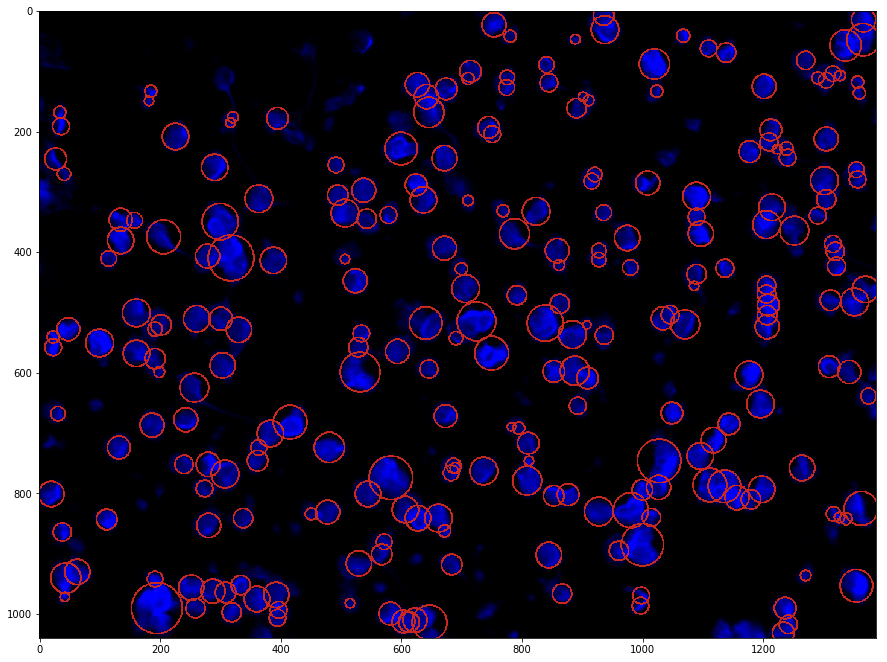

True

In [19]:
%matplotlib inline
# import libraries
import cv2
import numpy as np

from matplotlib import pyplot as plt

from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

blue = cv2.imread('blue.jpg')
green = cv2.imread('green.jpg')
red = cv2.imread('red.jpg')
combined = cv2.imread('combined.jpg')

# this is the constant that gets multiplied by the radius to approximate the cell size
scaling_factor = 1

# convert red and green images to gray for later
red_gray = cv2.cvtColor(red, cv2.COLOR_BGR2GRAY)
green_gray = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)

## lists
red = []
green = []
cat = []
centers = []

# blur
blurred = cv2.bilateralFilter(blue ,9,75,75)
# convert to gray
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

# threshold
_, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)


# watershed
D = ndimage.distance_transform_edt(thresh)

### this min_distance parameter is really important
localMax = peak_local_max(D, indices=False, min_distance= 5, labels=thresh)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)



for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue

    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)[-2]
    c = max(cnts, key=cv2.contourArea)
    
    if cv2.contourArea(c) > 100:
            
        # find the average intensity of the red stain contour
        mask = np.zeros(red_gray.shape,np.uint8)
        # get the enclosing circle of the contour
        ((x, y), r) = cv2.minEnclosingCircle(c)
        # draw the circle on an empty image to ask as a mask
        cv2.circle(mask, (int(x), int(y)), int(r*scaling_factor), 1, thickness=-1)
#         masked_red = cv2.bitwise_and(red_grey, red_grey, mask = mask)

        # get average strength of the red and green signals
        avg_red = cv2.mean(red_gray, mask = mask)[0]
        avg_green = cv2.mean(green_gray, mask = mask)[0]
        
        # add to lists
        red.append(avg_red)
        green.append(avg_green)
        centers.append((int(x), int(y)))
        
        # make into categories
        if avg_green > 20 and avg_red > 10:
            cat.append("both")
        elif avg_green <= 20 and avg_red > 10:
            cat.append("red")
        elif avg_green > 20 and avg_red <= 10:
            cat.append("green")
        else:
            cat.append("nada")

        # draw a circle enclosing the object
        ((x, y), r) = cv2.minEnclosingCircle(c)
        cv2.circle(blue, (int(x), int(y)), int(r), (29, 40, 200), 2)
        if cat[-1] == "nada":
            cv2.circle(combined, (int(x), int(y)), 7, (255, 60, 50), -1)
        if cat[-1] == "red":
            cv2.circle(combined, (int(x), int(y)), 7, (19, 50, 255), -1)
        if cat[-1] == "green":
            cv2.circle(combined, (int(x), int(y)), 7, (19, 255, 20), -1)
        if cat[-1] == "both":
            cv2.circle(combined, (int(x), int(y)), 7, (255, 255, 255), -1)
#         cv2.putText(combined, "{}: {}".format(label, cat[-1]), (int(x) - 10, int(y)),
#             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (29, 40, 200), 2)

        
print("number of nuclei identified: {}".format(len(cat)))

# show the result
plt.figure(figsize=(15,15))
(B, G, R) = cv2.split(blue)
image = cv2.merge([R, G, B])
plt.imshow(image)
plt.show()

cv2.imwrite("watershed.jpg", blue)
cv2.imwrite("combined_with_measures.jpg", combined)


The photo above is the result of the program trying to find nuceli. It rejects nuclei that are smaller than a certain size. 

You can see some problems: when cells are heavily clumpted together, the program classifies them as a single cell. This will require some more tweaking to get right.

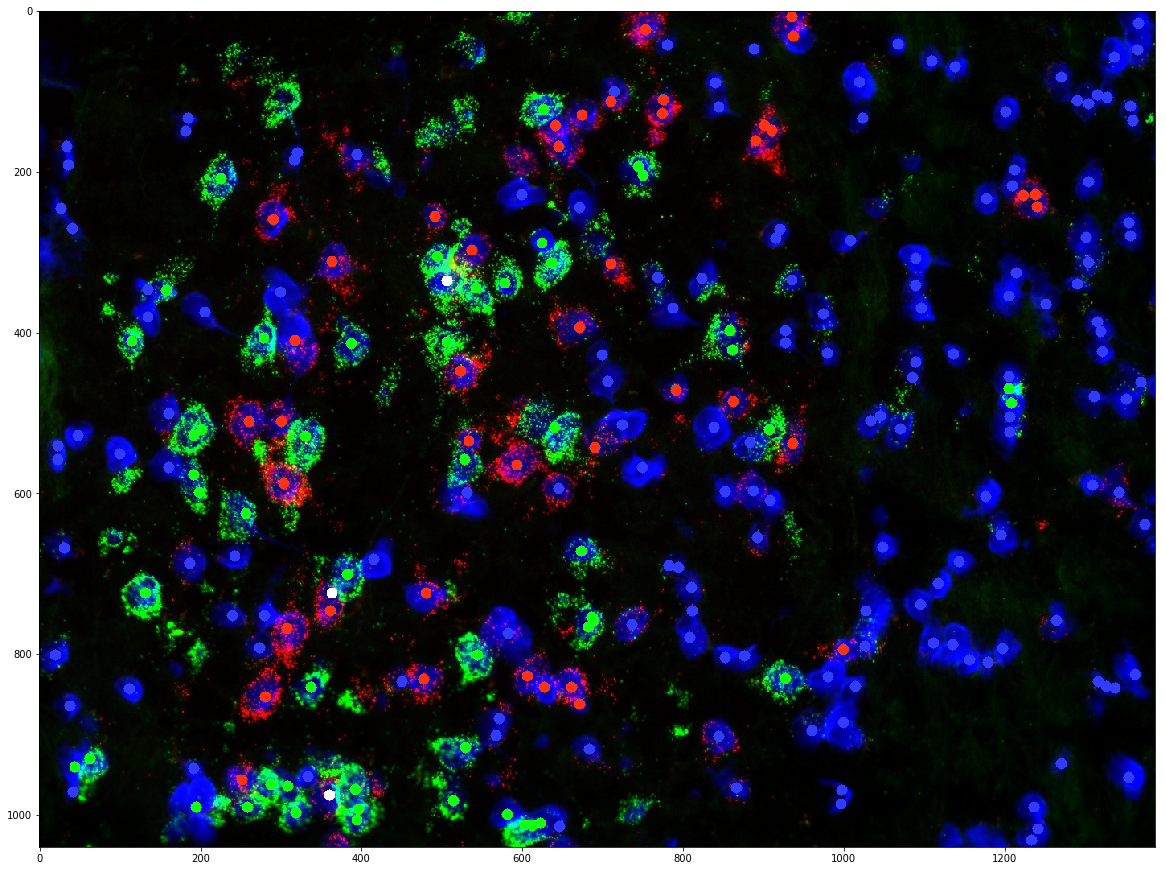

In [20]:

plt.figure(figsize=(20,20))
(B, G, R) = cv2.split(combined)
image = cv2.merge([R, G, B])
plt.imshow(image)
plt.show()

The program has put a dot on each thing it considers a cell. The color of the dot corresponds to whether it marked the cell as containing no fluorescence (blue), red fluorescence (red), green fluorescence (green), or coexpression (white).

It does a pretty good job, but 3 / ~250 cells are identified as having coexpression; it looks like the more likely scenario is that the identified cell is expressing red and adjacent cells are expressing green.

Below I give the distribution of how cells in this image where classified:

In [18]:
import pandas as pd
categories = pd.Series(cat)
categories.value_counts()

nada     156
green     52
red       43
both       3
dtype: int64